In [1845]:
import pandas as pd
import regex as re
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import feature_selection as f_select
from scipy import stats

import diagnostic_plots_rrs as diag

import warnings
warnings.filterwarnings("ignore")

In [1846]:
### Load Launch data

In [1847]:
df_ao = pd.read_csv('~/ds/metis/metis-w2/phone-launch.csv')
df_ao.columns = ['brand', 'model', 'year_launch']

In [1848]:
df_ao.model = df_ao.model.str.strip()

#df_ao = df_ao.drop(['launch_price', 'capacity'], axis=1)
df_ao.head()

,brand,model,year_launch
0,Apple,iPhone 4,2011
1,Apple,iPhone 4s,2011
2,Apple,iPhone 5,2012
3,Apple,iPhone 5c,2013
4,Apple,iPhone 5s,2013


### Load & Cleanup Scrapped Data

In [1849]:
# #Samsung Data
# %store -r dfs3

# df = dfs3
# df.tail()

In [1850]:
#Apple Data
%store -r dfs
%store -r dfs2
%store -r dfs3
%store -r dfs4

df = dfs
df = df.append(dfs2, ignore_index=True)
df = df.append(dfs3, ignore_index=True)
df = df.append(dfs4, ignore_index=True)
df.tail()

,URL,response,name,condition,sold,year_sold,sold_price,free_shipping,accept_return
22518,https://www.ebay.com/itm/In-OEM-Box-Apple-iPho...,200,In OEM Box Apple iPhone SE 32GB Space Gray (GS...,Used,4,2018,124.99,1,1
22519,https://www.ebay.com/itm/Apple-iPhone-8-Plus-2...,listing_ended,0,0,0,0,0,0,0
22520,https://www.ebay.com/itm/Apple-iPhone-6s-16GB-...,listing_ended,0,0,0,0,0,0,0
22521,https://www.ebay.com/itm/Near-Mint-Apple-iPhon...,200,Near Mint Apple iPhone 5C White 8GB Verizon Un...,Used,3,2018,63.00,1,1
22522,https://www.ebay.com/itm/Good-Apple-iPhone-5-B...,200,Good Apple iPhone 5 Black Color 16GB Factory U...,Used,15,2018,69.00,1,1


In [1851]:
#Filtering 'Used' condition only
df_01 = df[df.condition == 'Used'].reset_index(drop = True)

#Adding brand, model, & capacity
df_01['brand'] = df_01['name'].str.split(' ').str[0]
df_01['capacity'] = df_01['name'].str.split('GB').str[0].str.split(' ').str[-1] + 'GB'
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9123 entries, 0 to 9122
Data columns (total 11 columns):
URL              9123 non-null object
response         9123 non-null object
name             9123 non-null object
condition        9123 non-null object
sold             9123 non-null object
year_sold        9123 non-null object
sold_price       9123 non-null object
free_shipping    9123 non-null object
accept_return    9123 non-null object
brand            9123 non-null object
capacity         9123 non-null object
dtypes: object(11)
memory usage: 784.1+ KB


In [1852]:
# Data cleanup
df_01['model_a'] = df_01['name'].str.split(' ').str[1:3]
for index, model in enumerate(df_01['model_a']):
    df_01['model_a'][index] = ' '.join(model)
    
df_01['model_b'] = df_01['name'].str.split(' ').str[3]
df_01['model'] = df_01['model_b']
df_01['model_b'] = df_01['model_b'].str.replace(r'^(?!Plus|Edge).*', '')

for i in range(len(df_01['model_a'])):
    df_01['model'][i] = ' '.join([str(df_01['model_a'][i]), str(df_01['model_b'][i])])
    
df_01['model'] = df_01['model'].str.strip()
df_01 = df_01.drop(['model_a', 'model_b'], axis = 1)
df_01['model'] = df_01['model'].str.replace('GALAXY', 'Galaxy')

df_01['brand'] = df_01['brand'].str.replace('SAMSUNG', 'Samsung')
df_01['capacity'] = df_01['capacity'].str.replace(r'^(?!2GB|4GB|8GB|16GB|32GB|64GB|128GB|256GB).*','-')

## Merge & Cleanup

In [1853]:
# Merge ebay & launch data
df_merge = pd.merge(df_01, df_ao, how='inner', on=['brand','model'])

In [1854]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5253 entries, 0 to 5252
Data columns (total 13 columns):
URL              5253 non-null object
response         5253 non-null object
name             5253 non-null object
condition        5253 non-null object
sold             5253 non-null object
year_sold        5253 non-null object
sold_price       5253 non-null object
free_shipping    5253 non-null object
accept_return    5253 non-null object
brand            5253 non-null object
capacity         5253 non-null object
model            5253 non-null object
year_launch      5253 non-null int64
dtypes: int64(1), object(12)
memory usage: 574.5+ KB


In [1855]:
# dataset = ['model', 'capacity', 'year_launch', 'launch_price', 'free_shipping', 'accept_return', 'year_sold', 'sold', 'sold_price']
# feature = ['model', 'capacity', 'year_launch', 'launch_price', 'free_shipping', 'accept_return', 'year_sold', 'sold']

dataset = ['brand', 'model', 'capacity', 'year_launch', 'free_shipping', 'accept_return', 'year_sold', 'sold', 'sold_price']
feature = ['brand', 'model', 'capacity', 'year_launch', 'free_shipping', 'accept_return', 'year_sold', 'sold']

df_model = df_merge[dataset]

In [1856]:
# Cleanup non-numeric character
df_model['sold_price'] = df_model.sold_price.str.strip().str.replace('\'','').str.replace(',','')
df_model['sold'] = df_model.sold.str.strip().str.replace(',','')

# Convert to numeric & fill NaN
df_model.iloc[:,3:] = df_model.iloc[:,3:].apply(pd.to_numeric)
df_model.sold_price.fillna(0, inplace=True)
df_model.sold.fillna(1, inplace=True)

# Filter
df_model = df_model[df_model['sold_price'] > 0]

### Split Data

In [1857]:
dfs = X.join(y)
dfs[dfs.brand == 'Apple']['sold_price'].mean()

265.65401334604104

In [1858]:
X = df_model[feature]
y = df_model['sold_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 10)

### Model Building
#### Checking variables correlation

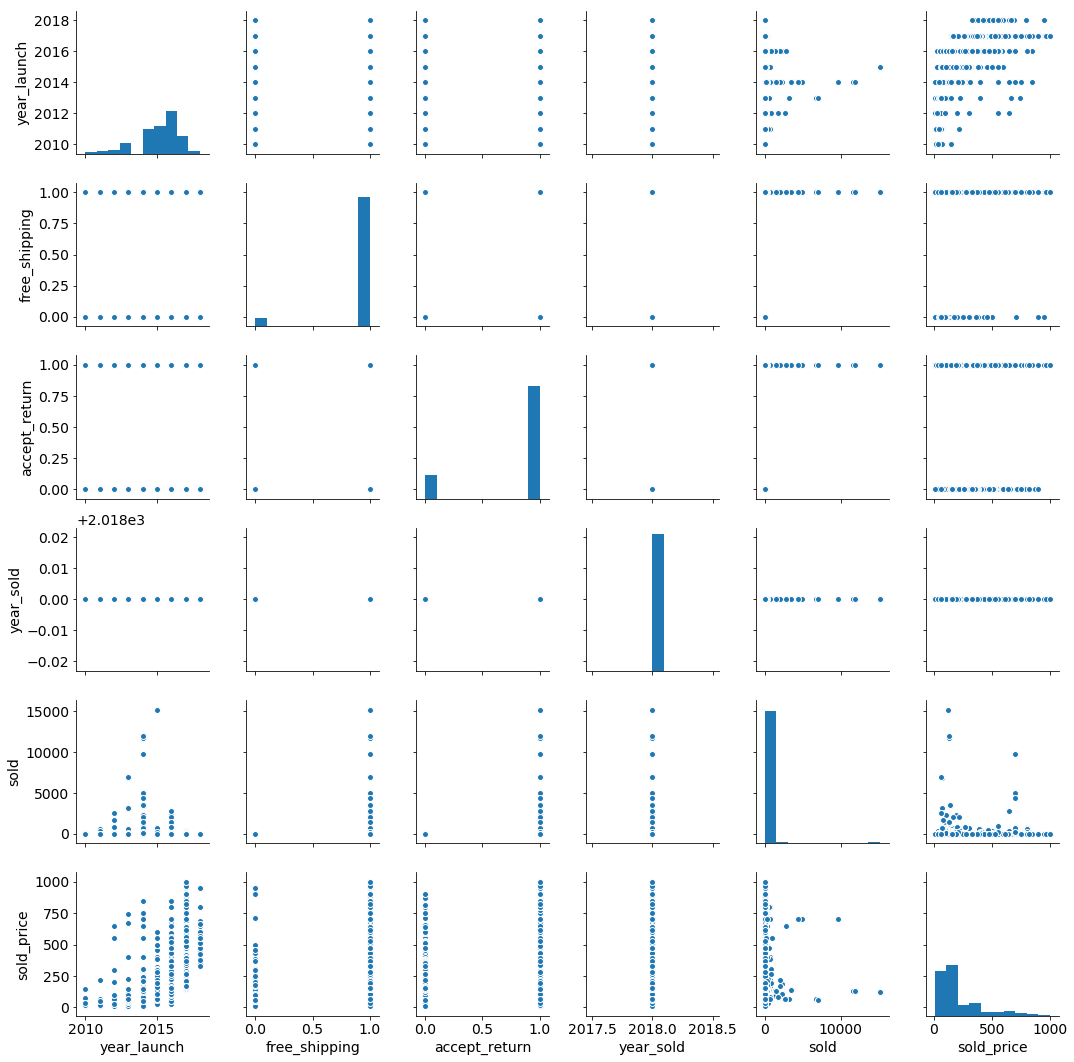

In [1859]:
# Check feature correlation
Xy_train = X_train.join(y_train)
sns.pairplot(Xy_train)

#### Non-normal target distribution -> apply log transformation

In [1860]:
# Convert soldprice to log
y_train_log = np.log(y_train)
y_train_log.head()

y_test_log = np.log(y_test)

(array([   8.,   30.,   84.,  270.,  740., 1132.,  431.,  449.,  229.,
         239.]),
 array([2.35042242, 2.80615571, 3.26188899, 3.71762228, 4.17335557,
        4.62908885, 5.08482214, 5.54055542, 5.99628871, 6.45202199,
        6.90775528]),
 <a list of 10 Patch objects>)

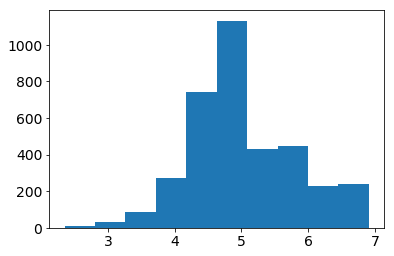

In [1331]:
plt.hist(y_train_log)

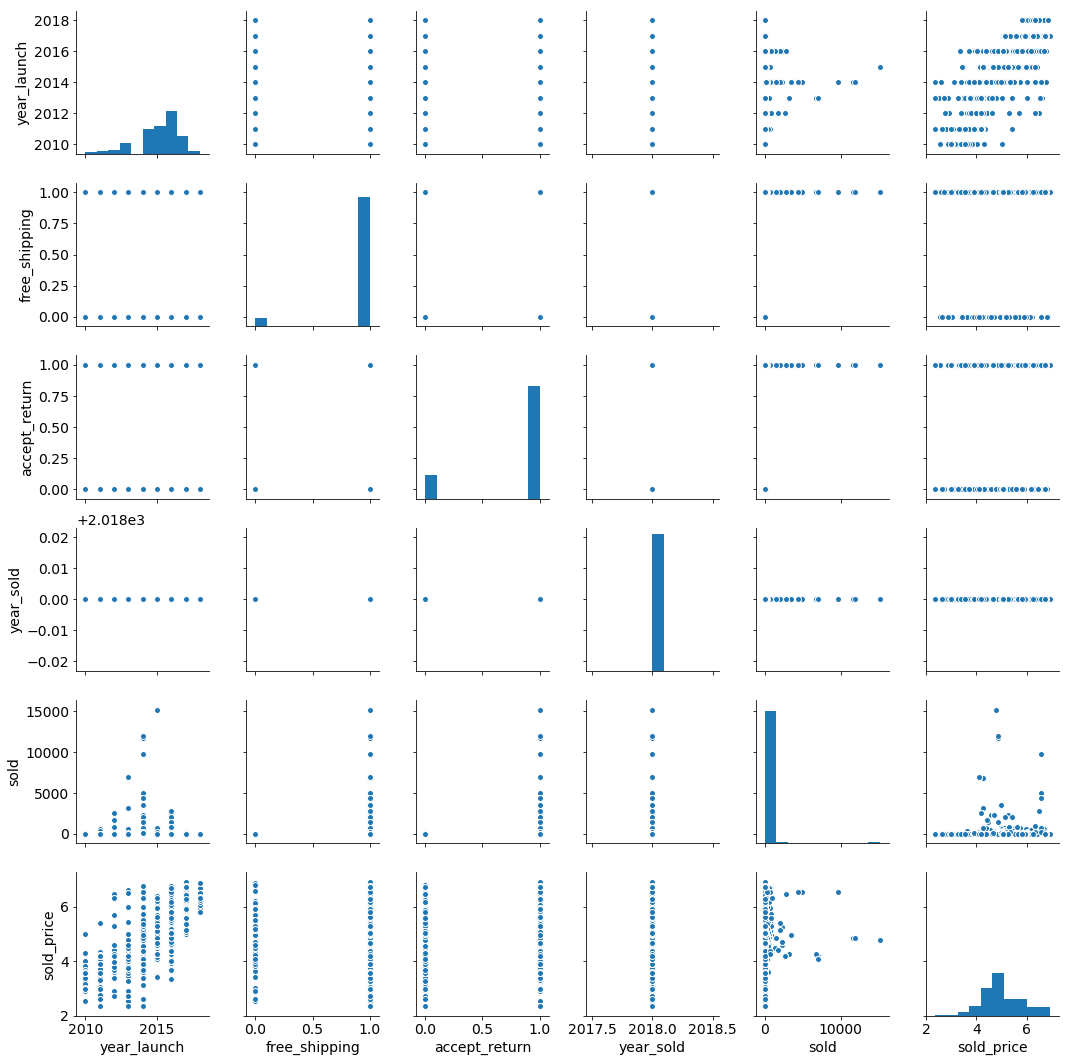

In [1861]:
Xy_train_log = X_train.join(y_train_log)
sns.pairplot(Xy_train_log)

** Creating indicator variables for categorial feature**

In [1862]:
# Create indicator variables
X_train_model = patsy.dmatrix('model', data = X_train, return_type = 'dataframe')
X_train_model = X_train_model.drop('Intercept', axis=1)
X_train_brand = patsy.dmatrix('brand', data = X_train, return_type = 'dataframe')
X_train_brand = X_train_brand.drop('Intercept', axis=1)
X_train_capacity = patsy.dmatrix('capacity', data = X_train, return_type = 'dataframe')

# Merge to X_train
X_train = X_train.join(X_train_model)
X_train = X_train.join(X_train_capacity)
X_train = X_train.join(X_train_brand)
X_train = X_train.drop(['brand', 'model', 'capacity'], axis=1)

# Create indicator variables
X_test_model = patsy.dmatrix('model', data = X_test, return_type = 'dataframe')
X_test_model = X_test_model.drop('Intercept', axis=1)
X_test_brand = patsy.dmatrix('brand', data = X_test, return_type = 'dataframe')
X_test_brand = X_test_brand.drop('Intercept', axis=1)
X_test_capacity = patsy.dmatrix('capacity', data = X_test, return_type = 'dataframe')

# Merge to X_test
X_test = X_test.join(X_test_model)
X_test = X_test.join(X_test_capacity)
X_test = X_test.join(X_test_brand)
X_test = X_test.drop(['brand', 'model', 'capacity'], axis=1)

X_test.head()

,year_launch,free_shipping,accept_return,year_sold,sold,model[T.Galaxy S2],model[T.Galaxy S3],model[T.Galaxy S4],model[T.Galaxy S5],model[T.Galaxy S6],...,Intercept,capacity[T.128GB],capacity[T.16GB],capacity[T.256GB],capacity[T.2GB],capacity[T.32GB],capacity[T.4GB],capacity[T.64GB],capacity[T.8GB],brand[T.Samsung]
1325,2017,1,1,2018,16.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1187,2013,1,1,2018,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3613,2016,1,0,2018,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4992,2017,1,1,2018,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3280,2016,1,1,2018,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [1863]:
model = sm.OLS(y_train_log, sm.add_constant(X_train))
model_fit = model.fit()

# Print summary statistics of the model's performance
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     336.7
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:39:42   Log-Likelihood:                -1428.5
No. Observations:                3612   AIC:                             2941.
Df Residuals:                    3570   BIC:                             3201.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year_launch                  0.2555      0.008     30.662      0.000       0.239       0.272
free_shipping                0.0336      0.027      1.242      0.214      -0.019       0.087
accept_return                0.2400      0.017     13.981      0.000       0.206       0.274
year_sold                   -0.2526      0.008    -30.369      0.000      -0.269      -0.236
sold                      1.636e-05   4.13e-06      3.964      0.000    8.27e-06    2.44e-05
model[T.Galaxy S2]          -0.3954      0.364     -1.087      0.277      -1.109       0.318
model[T.Galaxy S3]          -0.5775      0.082     -7.063      0.000      -0.738      -0.417
model[T.Galaxy S4]          -0.7462      0.044    -17.151      0.000      -0.832      -0.661
model[T.Galaxy S5]          -0.6463      0.037    -17.237      0.000      -0.720      -0.573
model[T.Galaxy S6]          -0.6948      0.031    -22.182      0.000      -0.756      -0.633
model[T.Galaxy S6 Edge]     -0.4454      0.050     -8.842      0.000      -0.544      -0.347
model[T.Galaxy S6 Edge+]    -0.2411      0.063     -3.836      0.000      -0.364      -0.118
model[T.Galaxy S7]          -0.6620      0.031    -21.370      0.000      -0.723      -0.601
model[T.Galaxy S7 Edge]     -0.1661      0.058     -2.880      0.004      -0.279      -0.053
model[T.Galaxy S8]          -0.0685      0.035     -1.975      0.048      -0.137      -0.000
model[T.Galaxy S8 Plus]      0.0664      0.150      0.442      0.658      -0.228       0.361
model[T.Galaxy S8+]         -0.0028      0.041     -0.070      0.944      -0.083       0.077
model[T.Galaxy S9]           0.2184      0.062      3.505      0.000       0.096       0.341
model[T.Galaxy S9 Plus]      0.5180      0.147      3.523      0.000       0.230       0.806
model[T.Galaxy S9+]          0.2284      0.056      4.098      0.000       0.119       0.338
model[T.iPhone 4]           -0.6989      0.079     -8.897      0.000      -0.853      -0.545
model[T.iPhone 4s]          -0.4889      0.055     -8.950      0.000      -0.596      -0.382
model[T.iPhone 5]           -0.2326      0.044     -5.286      0.000      -0.319      -0.146
model[T.iPhone 5c]          -0.6862      0.060    -11.388      0.000      -0.804      -0.568
model[T.iPhone 5s]          -0.3052      0.037     -8.283      0.000      -0.377      -0.233
model[T.iPhone 6]           -0.0701      0.022     -3.147      0.002      -0.114      -0.026
model[T.iPhone 6 Plus]       0.4266      0.044      9.639      0.000       0.340       0.513
model[T.iPhone 6s]          -0.1489      0.033     -4.574      0.000      -0.213      -0.085
model[T.iPhone 6s Plus]      0.2748      0.069      3.968      0.000       0.139       0.411
model[T.iPhone 7]            0.2207      0.035      6.249      0.000       0.151       0.290
model[T.iPhone

### Adding Polynomials

In [1341]:
# Adding Polynomials

kf = KFold(len(X_train), n_folds=5, shuffle=True, random_state=12)
degrees = range(1,4)

r2_mean_train = {}
r2_mean_test = {}

for degree in degrees:
    r2_test_scores = []
    r2_train_scores = []
    
    for train, test in kf:
        X_train_cv = X_train.iloc[train]
        y_train_cv = y_train_log.iloc[train]
        X_test_cv = X_train.iloc[test]
        y_test_cv = y_train_log.iloc[test]

        est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        est.fit(X_train_cv, y_train_cv)
        r2_train = est.score(X_train_cv, y_train_cv)
        r2_test = est.score(X_test_cv, y_test_cv)

        r2_test_scores.append(r2_test)
        r2_train_scores.append(r2_train)
    
    r2_mean_train[degree] = np.mean(r2_train_scores)
    r2_mean_test[degree] = np.mean(r2_test_scores)
        
r2_mean_train, r2_mean_test

({1: 0.7936916845659696, 2: 0.8335632877275854, 3: 0.8642723497014186},
 {1: 0.7885951147513255, 2: 0.7519690931021168, 3: -103312.87889614506})

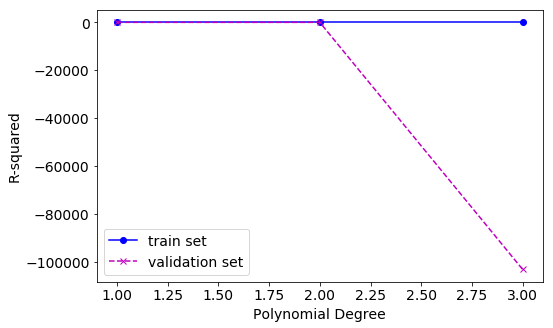

In [1344]:
plt.figure(figsize=(8,5))
plt.plot(r2_mean_train.keys(), r2_mean_train.values(), 'b-o', label='train set')
plt.plot(r2_mean_test.keys(), r2_mean_test.values(), 'm--x', label='validation set')
plt.legend(loc='lower left')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.savefig('polynomial.svg')

### Learning Curve

In [1348]:
est = LinearRegression()

train_sizes, train_scores, test_scores = learning_curve(est, X_train, y_train_log, cv=10, scoring='r2')

avg_train_scores = train_scores.mean(axis=1)
avg_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({'train_size': train_sizes, 'train_score': avg_train_scores, 'test_score': avg_test_scores})
learn_df

,train_size,train_score,test_score
0,325,0.820545,0.750995
1,1056,0.798040,0.781797
2,1787,0.801648,0.787527
3,2518,0.794392,0.788266
4,3250,0.793475,0.788685


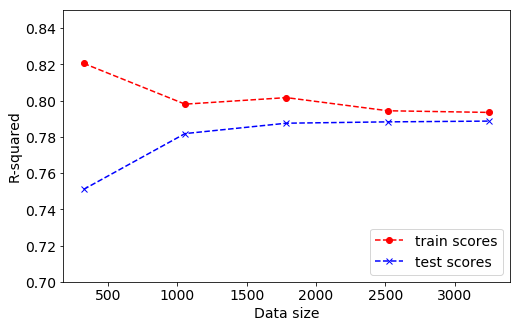

In [1353]:
plt.figure(figsize=(8,5))
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.legend(loc='lower right')
plt.ylim(0.7,0.85)
plt.xlabel('Data size')
plt.ylabel('R-squared')
plt.savefig('learning-curve.svg')

### Regularization - Lasso

In [1356]:
ssc = preprocessing.StandardScaler()

kf = KFold(len(X_train), n_folds=10, shuffle=True, random_state=23)
alphas = [10**i for i in range(-10,-1)]

alpha_score = []

for a in alphas:
    mse_score = []
    
    for train, test in kf:
        X_train_cv = X_train.iloc[train]
        y_train_cv = y_train_log.iloc[train]
        X_test_cv = X_train.iloc[test]
        y_test_cv = y_train_log.iloc[test]
        
        X_train_cv_norm = ssc.fit_transform(X_train_cv)
        X_test_cv_norm = ssc.transform(X_test_cv)
        
        est = Lasso(alpha=a)
        est.fit(X_train_cv_norm, y_train_cv)
        y_predict = est.predict(X_test_cv_norm)
        mse = mean_squared_error(y_test_cv, y_predict)
        mse_score.append(mse)
        
    alpha_score.append(np.mean(mse_score))
    
list(zip(alphas,alpha_score))

[(1e-10, 0.13350121831282763),
 (1e-09, 0.13350121820321273),
 (1e-08, 0.13350121710707058),
 (1e-07, 0.13350120614634772),
 (1e-06, 0.13350109660900975),
 (1e-05, 0.1334999005146059),
 (0.0001, 0.13348979342471123),
 (0.001, 0.13346983046509853),
 (0.01, 0.13830920197339452)]

Text(0,0.5,'MSE')

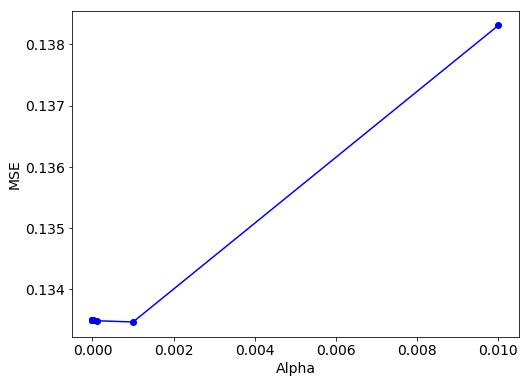

In [1357]:
plt.figure(figsize=(8,6))
plt.plot(alphas, alpha_score, 'b-o')
plt.xlabel('Alpha')
plt.ylabel('MSE')

In [1436]:
pvals = {}

for feature in X_train.columns:
    pval=f_select.f_regression(X_train[[feature]],y_train_log)
    pvals[feature] = pval[1][0]

sorted(pvals.items(), key=lambda x: x[1])

[('year_launch', 0.0),
 ('capacity[T.64GB]', 2.746205846331446e-185),
 ('model[T.iPhone X]', 1.4351674215571393e-90),
 ('accept_return', 1.9573031382675502e-07),
 ('free_shipping', 3.424848457128756e-06),
 ('year_sold', nan),
 ('capacity[T.16GB]', 5.195536670610715e-178),
 ('model[T.Galaxy S4]', 1.487296393264832e-61),
 ('model[T.iPhone 7]', 1.8693655189768645e-45),
 ('model[T.Galaxy S5]', 2.4696632864775275e-45),
 ('model[T.Galaxy S8]', 2.346457317663162e-44),
 ('model[T.iPhone 7 Plus]', 3.0969237068617063e-44),
 ('capacity[T.256GB]', 9.865433513763755e-44),
 ('model[T.iPhone 8 Plus]', 2.2794866382739165e-42),
 ('model[T.Galaxy S9+]', 9.865661311095777e-36),
 ('model[T.iPhone 4s]', 1.04956010798913e-34),
 ('capacity[T.128GB]', 9.054656552994479e-32),
 ('model[T.Galaxy S8+]', 1.0852188123544753e-28),
 ('model[T.Galaxy S6]', 5.66305567906339e-25),
 ('brand[T.Samsung]', 7.120072319277257e-24),
 ('model[T.Galaxy S9]', 1.1471217798525251e-23),
 ('model[T.iPhone 8]', 3.9791566872416344e-21)

In [1465]:
alpha = sorted(list(zip(alphas,alpha_score)), key = (lambda x: x[1]))[0][0]
X_train_norm = ssc.fit_transform(X_train)

est = Lasso(alpha=alpha)
est.fit(X_train_norm, y_train_log)
df_coef = pd.DataFrame(list(zip(X_train.columns,est.coef_)), columns = ['feature','coef'])

est.score(X_train_norm, y_train_log), alpha, df_coef

(0.7931008219334632, 0.001,                      feature      coef
 0                year_launch  0.392913
 1              free_shipping  0.013228
 2              accept_return  0.085356
 3                       sold  0.026504
 4         model[T.Galaxy S2] -0.010183
 5         model[T.Galaxy S3] -0.043624
 6         model[T.Galaxy S4] -0.130319
 7         model[T.Galaxy S5] -0.133818
 8         model[T.Galaxy S6] -0.209040
 9    model[T.Galaxy S6 Edge] -0.039975
 10  model[T.Galaxy S6 Edge+] -0.016942
 11        model[T.Galaxy S7] -0.216094
 12   model[T.Galaxy S7 Edge] -0.009903
 13        model[T.Galaxy S8]  0.012897
 14   model[T.Galaxy S8 Plus]  0.006658
 15       model[T.Galaxy S8+]  0.019676
 16        model[T.Galaxy S9]  0.033975
 17   model[T.Galaxy S9 Plus]  0.022696
 18       model[T.Galaxy S9+]  0.042713
 19         model[T.iPhone 4] -0.044997
 20        model[T.iPhone 4s] -0.045018
 21         model[T.iPhone 5] -0.016721
 22        model[T.iPhone 5c] -0.061986
 23        mo

### Removing Features

In [1359]:
list(df_coef[df_coef['coef'] == 0]['feature'])

['year_sold',
 'model[T.iPhone 6s]',
 'Intercept',
 'capacity[T.64GB]',
 'capacity[T.8GB]',
 'brand[T.Samsung]']

In [1442]:
rm_feature = list(df_coef[df_coef['coef'] == 0]['feature'])
X_train.drop(rm_feature , axis=1, inplace=True)
X_train_norm = ssc.fit_transform(X_train)
X_train.head()

,year_launch,free_shipping,accept_return,sold,model[T.Galaxy S2],model[T.Galaxy S3],model[T.Galaxy S4],model[T.Galaxy S5],model[T.Galaxy S6],model[T.Galaxy S6 Edge],...,model[T.iPhone 8],model[T.iPhone 8 Plus],model[T.iPhone SE],model[T.iPhone X],capacity[T.128GB],capacity[T.16GB],capacity[T.256GB],capacity[T.2GB],capacity[T.32GB],capacity[T.4GB]
3826,2015,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2987,2016,1,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3036,2016,1,1,125.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2948,2016,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
236,2017,1,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modelling

**Final Building**

In [1867]:
est = LinearRegression()

est.fit(X_train, y_train_log)
r2 = est.score(X_test, y_test_log)
mape = (np.sum(np.abs(np.exp(y_test_log) - np.exp(est.predict(X_test)))/np.exp(y_test_log))) * 100 / len(y_test_log)

r2, mape

(0.7980925006475634, 23.032576158959106)

**Cross Validation**

In [1533]:
#est = make_pipeline(PolynomialFeatures(1), LinearRegression())
kf = KFold(len(X_train), n_folds=10, shuffle=True, random_state=19)
est = Lasso(0.001)

r2_scores = []
rmse_scores = []
mse_scores = []
mape_scores = []

for train, test in kf:
    X_train_cv = X_train.iloc[train]
    y_train_cv = y_train_log.iloc[train]
    X_test_cv = X_train.iloc[test]
    y_test_cv = y_train_log.iloc[test]
            
    X_train_cv_norm = ssc.fit_transform(X_train_cv)
    X_test_cv_norm = ssc.transform(X_test_cv)
        
    est.fit(X_train_cv_norm,y_train_cv)
    r2 = est.score(X_test_cv_norm,y_test_cv)
    mse = (mean_squared_error(np.exp(y_test_cv), np.exp(est.predict(X_test_cv_norm))))
    rmse = np.sqrt(mse)
    mape = (np.sum(np.abs(np.exp(y_test_cv) - np.exp(est.predict(X_test_cv_norm)))/np.exp(y_test_cv))) * 100 / len(y_test_cv)
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mse_scores.append(mse)
    mape_scores.append(mape)
        
df_score = pd.DataFrame(list((np.mean(r2_scores), np.mean(rmse_scores), np.mean(mse_scores), np.mean(mape_scores))), index=['R-squared','RMSE ($)','MSE ($)','MAPE (%)'], columns=['Score'])
df_score

,Score
R-squared,0.787348
RMSE ($),94.756412
MSE ($),9102.262242
MAPE (%),24.165974


### Diagnotics

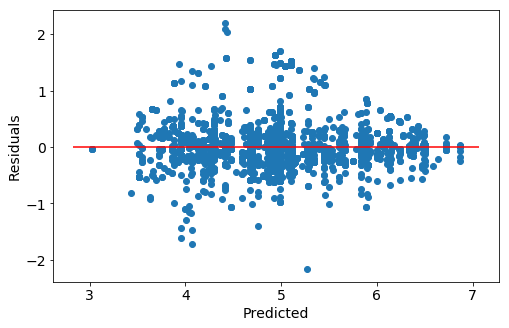

In [1408]:
est = Lasso(alpha=0.001)
est.fit(X_train_norm,y_train_log)
resid = y_train_log - est.predict(X_train_norm)

plt.figure(figsize=(8,5))
plt.scatter((est.predict(X_train_norm)), resid)
xmin, xmax = plt.xlim()
plt.hlines(0, xmin, xmax, colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.savefig('residual-actual.svg')

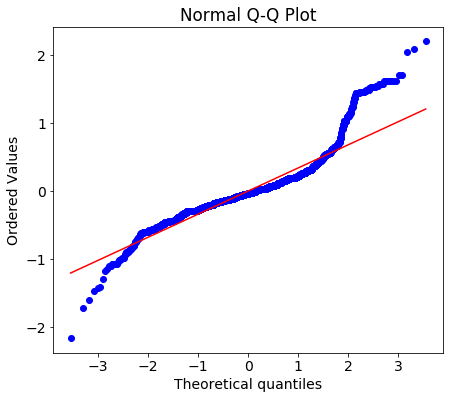

In [1409]:
plt.figure(figsize=(7,6))
stats.probplot(resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.savefig('qqplot.svg')

### Residuals

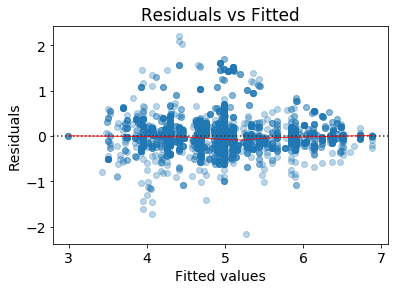

In [1650]:
Xy_train_log = X_train.join(y_train_log)

# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, Xy_train_log.columns[-1], data=Xy_train_log,
                          lowess=True,
                          scatter_kws={'alpha': 0.3},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');
#plt.savefig('residual-dummy.svg')